In [348]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle
import torch.utils.data as data
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Target high-dim performance functions

In [4]:
from juan_first_passage import juan_first_passage
#https://rprepo.readthedocs.io/en/latest/reliability_problems.html#sec-rp-300
# RP300 14 input variables - gaussian
#set_id 	 problem_id
# 1 	 15

from gfun_213_le_frame import gfun_213_le_frame
from le_frame import le_frame
import le_frame_rein
# https://rprepo.readthedocs.io/en/latest/_modules/gfun_213_le_frame.html#gfun_213_le_frame
# set_id	problem_id
# 1 	14

# Creating classes for AutoEncoder (AE) and Variational AE

In [ ]:
# class to create an Autoencoder object
class AE(torch.nn.Module):
    def __init__(self, in_dim):
        
        super().__init__()
         
        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        
        self.encoder = torch.nn.Sequential(
            nn.Linear(in_dim, 10),
            nn.LeakyReLU(0.1),
            nn.Linear(10, 7),
            nn.LeakyReLU(0.1),
            nn.Linear(7, 5),
            nn.LeakyReLU(0.1),
            nn.Linear(5, 3),
            )
         
        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        
        self.decoder = torch.nn.Sequential(
            nn.Linear(3, 5),
            nn.LeakyReLU(0.1),
            nn.Linear(5, 7),
            nn.LeakyReLU(0.1),
            nn.Linear(7, 10),
            nn.LeakyReLU(0.1),
            nn.Linear(10, in_dim),
            )
 
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [438]:
class VariationalAutoencoder_1(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        
        #encoder
        self.x_hidd = nn.Linear(in_dim, 7)  
        self.mu_hidd = nn.Linear(7, 3)  
        self.sigma_hidd = nn.Linear(7, 3)
        
        #decoder         
        self.decoder = torch.nn.Sequential(
        nn.Linear(3, 5),
        nn.ReLU(),
        nn.Linear(5, 10),
        nn.ReLU(),
        nn.Linear(10, in_dim),
        )
    
    def enconder(self, x):
        h = F.relu(self.x_hidd(x))
        mu, sigma = self.mu_hidd(h), self.sigma_hidd(h)
        return mu, sigma
        
    def forward(self, x):
        mu, sigma = self.enconder(x)
        epsilon = torch.randn_like(sigma)        #reparametrization trick?
        z_reparametrized = mu + sigma*epsilon
    
        x_reconstructed = self.decoder(z_reparametrized)
        return x_reconstructed, mu, sigma

In [463]:
# VariationalAutoencoder(14)

#model initialization
network_VAE = VariationalAutoencoder_1(14)   #size of high-dim input space
print(network_VAE)

VariationalAutoencoder_1(
  (x_hidd): Linear(in_features=14, out_features=7, bias=True)
  (mu_hidd): Linear(in_features=7, out_features=3, bias=True)
  (sigma_hidd): Linear(in_features=7, out_features=3, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=14, bias=True)
  )
)


In [ ]:
# we use the MSE loss as criterion
criterion = nn.MSELoss()

# we create an instance of the SGD class that will make the updates for us
# optimizer = optim.SGD(params= network.parameters(), lr=.1)
optimizer = optim.Adam(params= network_VAE.parameters(), lr = 5e-3)  #Karpathy constant?

train = data.TensorDataset(x_train, y_train)
trainloader = data.DataLoader(train, batch_size=32, shuffle=True)

test = data.TensorDataset(x_test, y_test)
testloader = data.DataLoader(test, batch_size=32, shuffle=False)

num_epochs = 100
train_avg_loss = []
test_avg_loss = []

device = 'cpu'

network_VAE.to(device)

for epoch in range(num_epochs):
    loop = tqdm(enumerate(trainloader))
    
    train_losses = []
    test_losses = []

    for i, (x, _) in loop:    #we can omit 'y' value 
        x = x.to(device) # GPU
        
        x_reconstructed, mu, sigma = network_VAE(x)
        
        reconstruction_loss = criterion(x_reconstructed, x)
        KL_div = -torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))

        loss = reconstruction_loss + KL_div
        
        train_losses.append(loss.detach())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loop.set_postfix(loss=loss.item())

    with torch.no_grad():   

        for x, _ in testloader:
            x = x.to(device) # GPU
            
            x_reconstructed, mu, sigma = network_VAE(x)
            KL_div_test = torch.mean(-0.5 *torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2), dim = 1), dim = 0)
#             KL_div_test = -0.5 *torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))
    
            loss_test = criterion(x_reconstructed, x) + KL_div_test
            test_losses.append(loss_test)
        
    train_avg_loss.append(sum(train_losses)/len(train_losses))
    test_avg_loss.append(sum(test_losses)/len(test_losses))

# Move everything back to the CPU
train_avg_loss = torch.tensor(train_avg_loss, device = 'cpu')
test_avg_loss = torch.tensor(test_avg_loss, device = 'cpu')

fig, axs = plt.subplots(1, 1)
axs.set_title('Training Loss')
axs.plot(train_avg_loss)
axs.plot(test_avg_loss)
axs.set_xlabel('Iterations')
axs.set_ylabel('Loss (MSELoss)')
plt.show()

2344it [00:11, 207.37it/s, loss=0.935]
2344it [00:10, 222.50it/s, loss=1.03] 
2344it [00:09, 260.17it/s, loss=0.906]
2344it [00:09, 237.74it/s, loss=0.928]
1736it [00:07, 201.71it/s, loss=0.996]

In [313]:
class VariationalEncoder(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        
        self.linear1 = nn.Linear(in_dim, 8)
        self.linear2 = nn.Linear(8, 3)     #to output the mean
        self.linear3 = nn.Linear(8, 3)     #to output the std. dev.
        
    def forward(self, x):
        
        x = F.relu(self.linear1(x))   
        self.mu =  self.linear2(x)
        self.sigma = (self.linear3(x))    #torch.exp(self.linear3(x))    #exponential to ensure positive values?
        
        z = self.mu + self.sigma*self.N.sample(self.mu.shape)   #reparametrization trick?
        z = 
        
        self.kl2 = torch.sum(((self.sigma**2 + self.mu**2)*0.5 + torch.log(1/self.sigma) ) - 1/2
        self.kl = (self.sigma**2 + self.mu**2 - torch.log(self.sigma) - 1/2).sum()
        
        return z
    
class VariationalAutoencoder(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.encoder = VariationalEncoder(in_dim)
                
        self.decoder = torch.nn.Sequential(
        nn.Linear(3, 7),
        nn.ReLU(),
        nn.Linear(7, 10),
        nn.ReLU(),
        nn.Linear(10, in_dim),
        )
        
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [314]:
network_test = VariationalAutoencoder(14)
print(network_test)

VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (linear1): Linear(in_features=14, out_features=8, bias=True)
    (linear2): Linear(in_features=8, out_features=3, bias=True)
    (linear3): Linear(in_features=8, out_features=3, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=5, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=5, out_features=7, bias=True)
    (3): LeakyReLU(negative_slope=0.1)
    (4): Linear(in_features=7, out_features=10, bias=True)
    (5): LeakyReLU(negative_slope=0.1)
    (6): Linear(in_features=10, out_features=14, bias=True)
  )
)


In [127]:
x,_ = next(iter(trainloader))

In [341]:
VariationalEncoder(x)

TypeError: empty(): argument 'size' must be tuple of ints, but found element of type Tensor at pos 2

In [315]:
z_latent = network_test.encoder.forward(x)

x_reconstr = network_test.decoder(z_latent)

In [316]:
network_test.encoder.kl

tensor(14.4473, grad_fn=<SumBackward0>)

In [317]:
network_test.encoder.kl2

tensor(0.9573, grad_fn=<SumBackward0>)

In [339]:
input_dist = torch.log((network_test.encoder.mu) + (network_test.encoder.sigma))

In [336]:
target_dist = network_test.encoder.mu + network_test.encoder.sigma*network_test.encoder.N.sample(network_test.encoder.mu.shape)

In [330]:
target_dist = network_test.encoder.N.sample(network_test.encoder.mu.shape)

In [449]:
target_dist.shape

torch.Size([8, 3])

In [458]:
torch.sum(torch.sum(target_dist, dim = 0))

tensor(1.2029, grad_fn=<SumBackward0>)

In [457]:
torch.sum(target_dist)

tensor(1.2029, grad_fn=<SumBackward0>)

In [311]:
torch.mean(target_dist, dim=0)

tensor([ 0.2824, -0.1817,  0.4688])

In [332]:
loss_kl = nn.KLDivLoss(reduction="batchmean")

In [340]:
loss_kl(input_dist, target_dist)

tensor(0.3836, grad_fn=<DivBackward0>)

In [318]:
criterion(x_reconstr, x)

tensor(1.2134, grad_fn=<MseLossBackward0>)

In [ ]:
shapeL1 = network_VAE.encoder.linear1(x_sample).shape

In [ ]:
device

In [ ]:
x_sample = torch.from_numpy(x_dataset[0].astype(np.float32))

x_sample = x_sample.to(device)

network_VAE.encoder(x_sample)

In [ ]:
x_train = torch.from_numpy(x_dataset[n_split:])

In [ ]:
torch.exp(torch.distributions.Normal(0, 1).sample(shapeL1))

In [ ]:
# VariationalAutoencoder(14)

Generating samples and splitting the data for training and test

In [42]:
n_samples = 10**5

# x_dataset_2 = np.random.normal(0, 1 , size=(n_samples, 14) )

# y_dataset_2 = juan_first_passage(x_dataset_2)

## pf estimation with dataset
np.sum(y_dataset < 0)/len(y_dataset)

5e-05

In [102]:
# reading external dataset file 
filename_data = 'DataSet_RP300_10e5.sav'
dataset = pickle.load(open(filename_data, 'rb'))
x_dataset = dataset[:, 0:14]
y_dataset = dataset[:, 14]

# x_train, x_test, y_train, y_test = train_test_split(x_dataset, y_dataset, test_size=0.25, random_state=73)  # create splits

In [44]:
# dataset[:, 0:14] = x_dataset_2
# dataset[:, 14] = y_dataset_2

# filename_data = 'DataSet_RP300_10e6.sav'
# pickle.dump(dataset, open(filename_data, 'wb'))

n_split = int(0.3 * n_samples) #splitting 30 - 70 %

x_train = torch.from_numpy(x_dataset[n_split:].astype(np.float32))
y_train = torch.from_numpy(y_dataset[n_split:].astype(np.float32)).view(-1,1)

x_test = torch.from_numpy(x_dataset[:n_split].astype(np.float32))
y_test = torch.from_numpy(y_dataset[:n_split].astype(np.float32)).view(-1,1)

In [125]:
x_train, x_test, y_train, y_test = train_test_split(x_dataset, y_dataset, test_size=0.25, random_state=73)  # create splits
x_train = torch.from_numpy(x_train.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32)).view(-1,1)

x_test = torch.from_numpy(x_test.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32)).view(-1,1)

Setting up losses criterion, optimizer and dataloaders

In [ ]:
if torch.cuda.is_available() == True:
    device = 'cuda'
else:
    device = 'cpu'
    
print(device)

In [ ]:
# filename_data = 'network_MLP.sav'
# pickle.dump(network, open(filename_data, 'wb'))

# VAE

In [17]:
# VariationalAutoencoder(14)

#model initialization
network_VAE = VariationalAutoencoder(14)   #size of high-dim input space
print(network_VAE)

VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (linear1): Linear(in_features=14, out_features=8, bias=True)
    (linear2): Linear(in_features=8, out_features=3, bias=True)
    (linear3): Linear(in_features=8, out_features=3, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=5, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=5, out_features=7, bias=True)
    (3): LeakyReLU(negative_slope=0.1)
    (4): Linear(in_features=7, out_features=10, bias=True)
    (5): LeakyReLU(negative_slope=0.1)
    (6): Linear(in_features=10, out_features=14, bias=True)
  )
)


In [126]:
# we use the MSE loss as criterion
criterion = nn.MSELoss()

# we create an instance of the SGD class that will make the updates for us
# optimizer = optim.SGD(params= network.parameters(), lr=.1)
optimizer = optim.Adam(params= network_VAE.parameters(), lr = 1e-3, weight_decay = 1e-8)

train = data.TensorDataset(x_train, y_train)
trainloader = data.DataLoader(train, batch_size=8, shuffle=True)

test = data.TensorDataset(x_test, y_test)
testloader = data.DataLoader(test, batch_size=8, shuffle=False)

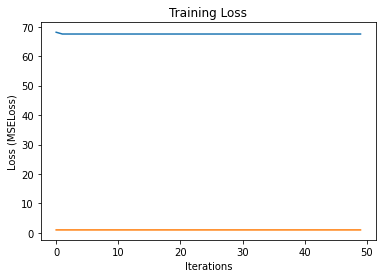

In [19]:
num_epochs = 50
train_avg_loss = []
test_avg_loss = []

device = 'cpu'

network_VAE.to(device)

for i in range(num_epochs):

    train_losses = []
    test_losses = []

    for x, _ in trainloader:    #we can omit 'y' value 
        x = x.to(device) # GPU
        
        reconstructed = network_VAE(x)
        loss = criterion(reconstructed, x) + network_VAE.encoder.kl
        train_losses.append(loss.detach())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    with torch.no_grad():   

        for x, _ in testloader:
            x = x.to(device) # GPU
            
            reconstructed = network_VAE(x)
            loss = criterion(reconstructed, x)
            test_losses.append(loss)

    train_avg_loss.append(sum(train_losses)/len(train_losses))
    test_avg_loss.append(sum(test_losses)/len(test_losses))

# Move everything back to the CPU
train_avg_loss = torch.tensor(train_avg_loss, device = 'cpu')
test_avg_loss = torch.tensor(test_avg_loss, device = 'cpu')

fig, axs = plt.subplots(1, 1)
axs.set_title('Training Loss')
axs.plot(train_avg_loss)
axs.plot(test_avg_loss)
axs.set_xlabel('Iterations')
axs.set_ylabel('Loss (MSELoss)')
plt.show()

In [ ]:
torch.cuda.empty_cache()

In [ ]:
fig, axs = plt.subplots(1, 1)
axs.set_title('Training Loss')
axs.plot(train_avg_loss)
axs.plot(test_avg_loss)
axs.set_xlabel('Iterations')
axs.set_ylabel('Loss (MSELoss)')
plt.show()

# Training AE

In [ ]:
#model initialization
network_AE = AE(14)   #size of high-dim input space
print(network_AE)

In [ ]:
# we use the MSE loss as criterion
criterion = nn.MSELoss()

# we create an instance of the SGD class that will make the updates for us
# optimizer = optim.SGD(params= network.parameters(), lr=.1)
optimizer = optim.Adam(params= network_AE.parameters(), lr = 1e-3, weight_decay = 1e-8)

train = data.TensorDataset(x_train, y_train)
trainloader = data.DataLoader(train, batch_size=128, shuffle=True)

test = data.TensorDataset(x_test, y_test)
testloader = data.DataLoader(test, batch_size=128, shuffle=False)

In [105]:
x, _ in trainloader

(tensor([[-0.4802, -1.2490,  1.6753, -0.8688,  0.3083, -2.2746,  1.3434, -0.4604,
           0.1526, -0.0868,  0.1575,  1.5750,  0.3654, -0.9355],
         [ 0.2175, -0.9641,  1.0017,  1.2289, -0.1299,  1.5098, -0.3451, -0.0402,
           0.2424,  1.2978,  2.0415, -1.0528,  0.1025,  0.4606],
         [ 1.5176, -0.9983,  0.4086,  0.4517,  1.3321, -1.0839,  0.4787, -0.2173,
           0.8907,  0.4958, -0.0428,  0.0357, -1.0243, -0.8162],
         [ 0.0281,  0.3725, -0.7837,  0.6350,  0.2843, -0.2053,  0.0142, -0.0343,
          -1.5186,  2.1642, -0.9725,  0.7644,  0.1559,  0.3771],
         [-0.6112, -0.5334, -0.3920, -0.2442,  1.3271,  0.9063, -0.8039, -1.9579,
           0.6331,  0.4457, -1.1984,  1.7865, -0.6967, -0.6974],
         [-0.9532,  0.7419,  0.2524, -0.6380,  0.4273, -2.0657, -1.0202,  0.6986,
           2.0891, -0.0048, -1.0344,  0.1775,  0.1751,  0.8058],
         [-2.6814,  0.7395,  0.6061, -0.9709, -1.6633,  1.0674, -1.2036, -1.3949,
           0.2058, -0.6143, -0.3429,

In [ ]:
x

In [ ]:
num_epochs = 50
train_avg_loss = []
test_avg_loss = []

# device = 'cpu'

network_AE.to(device)

for i in range(num_epochs):

    train_losses = []
    test_losses = []

    for _, _ in trainloader:    #we can omit 'y' value 
        x = x.to(device)
        
        reconstructed = network_AE(x)
        loss = criterion(reconstructed, x)
        train_losses.append(loss.detach())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    with torch.no_grad():   

        for _, _ in testloader:
#             x = x.to(device)
            
            reconstructed = network_AE(x)
            loss = criterion(reconstructed, x)
            test_losses.append(loss)

    train_avg_loss.append(sum(train_losses)/len(train_losses))
    test_avg_loss.append(sum(test_losses)/len(test_losses))
    
# Move everything back to the CPU
train_avg_loss = torch.tensor(train_avg_loss, device = 'cpu')
test_avg_loss = torch.tensor(test_avg_loss, device = 'cpu')

    
fig, axs = plt.subplots(1, 1)
axs.set_title('Training Loss')
axs.plot(train_avg_loss)
axs.plot(test_avg_loss)
axs.set_xlabel('Iterations')
axs.set_ylabel('Loss (MSELoss)')
plt.show()

In [ ]:
num_epochs = 100
train_avg_loss = []
test_avg_loss = []

# device = 'cpu'

network_AE.to(device)

for i in range(num_epochs):

    train_losses = []
    test_losses = []

    for x, _ in trainloader:    #we can omit 'y' value 
        x = x.to(device)
        
        reconstructed = network_AE(x)
        loss = criterion(reconstructed, x)
        train_losses.append(loss.detach())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    with torch.no_grad():   

        for x, _ in testloader:
            x = x.to(device)
            
            reconstructed = network_AE(x)
            loss = criterion(reconstructed, x)
            test_losses.append(loss)

    train_avg_loss.append(sum(train_losses)/len(train_losses))
    test_avg_loss.append(sum(test_losses)/len(test_losses))
    
# Move everything back to the CPU
train_avg_loss = torch.tensor(train_avg_loss, device = 'cpu')
test_avg_loss = torch.tensor(test_avg_loss, device = 'cpu')

    
fig, axs = plt.subplots(1, 1)
axs.set_title('Training Loss')
axs.plot(train_avg_loss)
axs.plot(test_avg_loss)
axs.set_xlabel('Iterations')
axs.set_ylabel('Loss (MSELoss)')
plt.show()

In [ ]:
#lr = 1e-3, batchsize=128, weight_decay = 1e-8
#latent = 5

# (encoder): Sequential(
#     (0): Linear(in_features=14, out_features=12, bias=True)
#     (1): LeakyReLU(negative_slope=0.1)
#     (2): Linear(in_features=12, out_features=10, bias=True)
#     (3): LeakyReLU(negative_slope=0.1)
#     (4): Linear(in_features=10, out_features=7, bias=True)
#     (5): LeakyReLU(negative_slope=0.1)
#     (6): Linear(in_features=7, out_features=5, bias=True)
#   )

# fig, axs = plt.subplots(1, 1)
# axs.set_title('Training Loss')
# axs.plot(train_avg_loss)
# axs.plot(test_avg_loss)
# axs.set_xlabel('Iterations')
# axs.set_ylabel('Loss (MSELoss)')
# plt.show()

Pf estimation

In [ ]:
# #loading network
# filename_data = 'network_MLP.sav'
# network = pickle.load(open(filename_data, 'rb'))

In [ ]:
point = 200
samplex = torch.from_numpy(x_dataset[point].astype(np.float32)).to(device)

y_dataset[point], network(samplex)

In [ ]:
np.sum(y_dataset < 0)/len(y_dataset)

In [ ]:
n_pred = 10**6
# x_pred = np.random.rand(n_pred, 14)
x_pred = np.random.normal(0, 1 , size=(n_samples, 14) )

x_pred = torch.from_numpy(x_pred.astype(np.float32)).to(device)

# x_pred = torch.randn(n_pred, 14, device=device)

y_pred = network(x_pred)   #MLP

np.sum(y_pred.cpu().detach().numpy() < 0)

# np.sum(y_pred < 0)/len(y_pred)

In [ ]:
x_pred

In [ ]:
counts, bins = np.histogram(y_pred.cpu().detach().numpy())
plt.stairs(counts, bins)

In [ ]:
network_AE = network_AE.to('cpu')

y_pred_AE = network_AE.encoder(x_pred)

y_pred_AE.shape

In [ ]:
lat_var = 2
counts, bins = np.histogram(y_pred_AE[:, lat_var].cpu().detach().numpy())
plt.stairs(counts, bins)

np.sum(y_pred.cpu().detach().numpy() < 0)

In [ ]:
negative = y_pred < 0
negative.sum(dim = 0)

In [ ]:
point = 10
samplex = x_dataset[point]
sampley = y_dataset[point]

samplex_torch = torch.from_numpy(x_dataset[point].astype(np.float32))

In [ ]:
np.array(sampley)

In [ ]:
(torch.from_numpy(np.array(sampley)) - network(samplex_torch))**2